# Intro to machine learning - Scikit-Learn

**Before this notebook, you should look at [Intro_to_pandas.ipynb](Intro_to_pandas.ipynb).**

In this notebook, we'll explore the Scikit Learn package for simple machine learning tasks using geoscience data examples. After this day, students will have a good overview of how to look at large datasets and solve problems with state-of-the-art machine learning tools.

- Machine learning concepts
- What is it that you’re trying to solve? How can machine learning help?
- What's the difference between supervised and unsupervised methods?
- What's the difference between classification and regression?


<img src="../data/ML_loop.png"></img>

### The machine learning iterative loop
- Data — Getting the data. How to load it and put it in an `array` and/or `DataFrame`
- Processing — data exploration, inspection, cleaning, and feature engineering.
- Model – What is a model? Training a Scikit-Learn model.
- Results – assessing quality and performance metrics (accuracy, recall, F1, confusion matrices)
- Repeat – What can we do to improve performance?

# Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data

In [3]:
import pandas as pd
dfs = pd.read_csv('../data/training_DataFrame_processed.csv')

---
# Scikit-learn classifiers

Let's create a model that classifies facies based on the various logs stored in the `DataFrame`


*Choosing the right estimator:* Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.
Different estimators are better suited for different types of data and different problems.

In [4]:
# Make X and y
X = dfs[['GR','RHOB','PE','ILD_log10']].values
y = dfs['s_Facies'].values

Some methods expect the data to be normalized. It's sometimes a good idea of normalizing it no matter which method you try

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

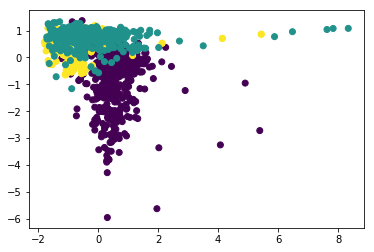

In [6]:
plt.scatter(X[:,0], X[:,1], c=dfs['Facies'].values)

Split the data into a training set and a test set. **This is a key step in the process.**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

We will also split the test set into two parts: one to **validate** against while training the model and selecting hypterparameters (sometimes also called the **dev** set), and one to assess the likely real-world performance of the trained model.

Note that you should only predict on the **test** set once, at the end of model selection and tuning.

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

A fairly common method for classifying data is to use the _k-nearest neighbors algorithm_. The label of the object in question is determined by the neighbouring data points in the feature space used. Its most important parameter, `k`, is the number of neighbors you include to make a membership decision.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

The next block is all you need to train a classifier model!

In [10]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [11]:
clf.predict(X_val)

array(['wackestone', 'f_siltstone', 'wackestone', 'f_siltstone',
       'f_siltstone', 'f_siltstone', 'f_siltstone', 'bafflestone',
       'f_siltstone', 'bafflestone', 'f_siltstone', 'wackestone',
       'bafflestone', 'wackestone', 'f_siltstone', 'bafflestone',
       'wackestone', 'wackestone', 'wackestone', 'wackestone',
       'f_siltstone', 'f_siltstone', 'f_siltstone', 'wackestone',
       'f_siltstone', 'f_siltstone', 'f_siltstone', 'f_siltstone',
       'bafflestone', 'f_siltstone', 'wackestone', 'f_siltstone',
       'f_siltstone', 'wackestone', 'bafflestone', 'f_siltstone',
       'f_siltstone', 'f_siltstone', 'bafflestone', 'f_siltstone',
       'f_siltstone', 'f_siltstone', 'wackestone', 'bafflestone',
       'f_siltstone', 'f_siltstone', 'wackestone', 'bafflestone',
       'f_siltstone', 'wackestone', 'wackestone', 'bafflestone',
       'f_siltstone', 'f_siltstone', 'f_siltstone', 'f_siltstone',
       'f_siltstone', 'wackestone', 'wackestone', 'wackestone',
       'f_sil

Before we can move on to a "production" setting and trust the predictions we need to create validation routines to make sure that the model we trained is _good_ and produces reasonble results. The most basic test is to look at how many good predictions we would make if we predict on our `Test` data.

In [12]:
score = clf.score(X_val, y_val)
print("The precision is {}%".format(np.round(score*100)))

The precision is 91.0%


This scoring is one of the _metrics_ we can use to check the quality of the predictions. There are a large number of different metrics and depending on your data and problem you may need to find the one that adjusts better to your needs. Typically, a more robust metric that is often used is called `F1`. It combines the `precision` score and a `recall` score (how many true positive predictions were made). Scikit-learn gives a nice summary of these three metrics using `classification_report`.

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_val, clf.predict(X_val), digits=3))

             precision    recall  f1-score   support

bafflestone      0.886     0.886     0.886        35
f_siltstone      0.940     0.940     0.940       134
 wackestone      0.861     0.861     0.861        79

avg / total      0.907     0.907     0.907       248



Depending on you requirements, this results might be good enough to deploy this model and use it on a "Machine Learning Pipeline" product but it is often not the best model you can get. Each method has a set of parameters (also known as _hyperparameters_) that can be tweaked to tune the training.

For the `KNeighborsClassifier` there are a few of these parameters:

In [14]:
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

For this particular method, the most important parameter to adjust is `n_neighbors` (it's the `K` in the `KNeighborsClassifier`!). Unfortunately, there's no rule that tells you what's the optimal value of `k`. To overcome this we can train many models with different values of `k` and compare the results of classifications applied to the _Test_ data.

In [15]:
nns = np.arange(1, 60, 2) # Generated array of values of k to try

Loop over each value in `nns` and store the `F1 Score`

In [16]:
from sklearn.metrics import f1_score

vals, trns = [], []
pvals, ptrns = [], []

for n in nns:
    clf = KNeighborsClassifier(n)
    clf.fit(X_train, y_train)

    trn = clf.score(X_train, y_train)
    trns.append(trn)

    val = clf.score(X_val, y_val)
    vals.append(val)
    
    y_pred = clf.predict(X_val)
    pvals.append(f1_score(y_val, y_pred, average='weighted'))
    y_ptrn = clf.predict(X_train)
    ptrns.append(f1_score(y_train, y_ptrn, average='weighted'))


What value of `n` gives us the best result?

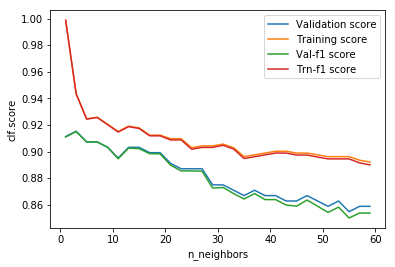

In [17]:
plt.plot(nns, vals, label="Validation score")
plt.plot(nns, trns, label="Training score")
plt.plot(nns, pvals, label="Val-f1 score")
plt.plot(nns, ptrns, label="Trn-f1 score")
_ = plt.xlabel('n_neighbors')
_ = plt.ylabel('clf.score')
_ = plt.legend()

## More methods to train models!

### For a classifier comparison check the source code [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

<img src="../data/ML_classifier_comparison_sklearn.png"></img>


Let's pick 3 different classifiers to train different models and then compare how well they perform. See the complete list of classifiers [here](http://scikit-learn.org/stable/supervised_learning.html).

Scikit-learn also has a handy [diagram](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to get started with model selection based on your data and target. 

In [18]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [19]:
classifiers = [
    SVC(),
    RandomForestClassifier(),
    MLPClassifier()
    ]

names = ["Linear SVM", "RandomForest", "Neural Network"]

In [20]:
classifiers

[SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle

Let's iterate over these classifiers and print common metrics to evaluate the performance of each model using the testing dataset we defined before

In [21]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    print("{:12} {}".format(name,"-"*15))
    print(classification_report(y_val, clf.predict(X_val), digits=3))

Linear SVM   ---------------
             precision    recall  f1-score   support

bafflestone      0.933     0.800     0.862        35
f_siltstone      0.941     0.948     0.944       134
 wackestone      0.831     0.873     0.852        79

avg / total      0.905     0.903     0.903       248

RandomForest ---------------
             precision    recall  f1-score   support

bafflestone      0.971     0.943     0.957        35
f_siltstone      0.925     0.925     0.925       134
 wackestone      0.863     0.873     0.868        79

avg / total      0.912     0.911     0.911       248

Neural Network ---------------
             precision    recall  f1-score   support

bafflestone      0.933     0.800     0.862        35
f_siltstone      0.934     0.948     0.941       134
 wackestone      0.829     0.861     0.845        79

avg / total      0.900     0.899     0.899       248



/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


- Go back to the list of available models and select new methods to try in the previous loop!

# Parameter selection

Many of the models can be improved (or worsened) by changing the parameters that internally make the method work. It's always a good idea to check the documentation of each model (e.g. RandomForestClassifier [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). This process is usually called _hyperparameter tuning_.

Scikit-learn offers a simple way to test different parameters for each model through a function called `GridSearchCV`

In [22]:
import time
from sklearn import metrics

def get_metrics(y_pred, y_true):  

    chosen_metrics = {
        'conf_mat': metrics.confusion_matrix,
        'accuracy': metrics.accuracy_score,
        'auc' : metrics.roc_auc_score,
    }

    results = {}
    for metric_name, metric_func in chosen_metrics.items():
        try:
            inter_res = metric_func(y_pred, y_true)
        except Exception as ex:
            inter_res = None
        results[metric_name] = inter_res

    results['conf_mat'] = results['conf_mat'].tolist()

    return results

In [23]:
import time

def _scorer(clf, X_val, y_val) -> float:
    
    # We need to use a global for timing.
    global LAST_TIME
    print(20 * '*')
    print(clf)
    
    # Get the score to return to GridSearchCV.
    y_pred = clf.predict(X_val)
    score = f1_score(y_pred, y_val, average='weighted')
    
    # Make & display the elapsed time.
    print(f"{score} >>> time: {time.time() - LAST_TIME: .5f} s")
    LAST_TIME = time.time()

    return score

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer as msc

# Select the parameters and values for each one to test
parameters = {'min_samples_leaf':np.arange(1, 100, 5),
              'max_depth':np.arange(1, 50, 5)}

rfc = RandomForestClassifier()

# Initialize the global for timing.
LAST_TIME = time.time()

# NB If timing, then only use one job, n_jobs=1.
clf = GridSearchCV(rfc, parameters, scoring=_scorer, cv=3, n_jobs=1, verbose=0)

clf.fit(X_train, y_train)

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8383988818199345 >>> time:  0.01865 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8328786163435662 >>> time:  0.00402 s
********************
RandomForestClassifie

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=21, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8259253903990745 >>> time:  0.01381 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=21, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8565597687620622 >>> time:  0.00356 s
********************
RandomForestClassif

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.8206682430864376 >>> time:  0.01395 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=41, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8460556529095413 >>> time:  0.00324 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=41, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8424833324047764 >>> time:  0.01437 s


/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=61, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8345925874818889 >>> time:  0.01430 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=61, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8435477725392092 >>> time:  0.00409 s
********************
RandomForestClassif

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=81, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8467142343206618 >>> time:  0.01500 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=81, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8500605650555998 >>> time:  0.00333 s
********************
RandomForestClassif

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9078030773466602 >>> time:  0.01725 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9717105940714079 >>> time:  0.00348 s
********************
RandomForestClassifie

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=21, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8610556212310337 >>> time:  0.01550 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=21, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8794038594351206 >>> time:  0.00273 s
********************
RandomForestClassif

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=41, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8615289628858827 >>> time:  0.01441 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=41, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8670002261283685 >>> time:  0.00286 s
********************
RandomForestClassif

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=61, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8607212516159273 >>> time:  0.01476 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=61, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8624414942472296 >>> time:  0.00288 s
********************
RandomForestClassif

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=81, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8426819762561457 >>> time:  0.01524 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=81, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8567606242107718 >>> time:  0.00321 s
********************
RandomForestClassif

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9043356354691456 >>> time:  0.01755 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
1.0 >>> time:  0.00302 s
********************
RandomForestClassifier(bootstrap=T

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8673816919118319 >>> time:  0.01737 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8948600266160048 >>> time:  0.00366 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8815968935808762 >>> time:  0.01630 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9019387022988029 >>> time:  0.00266 s
********************
RandomForestClass

0.8534803415130051 >>> time:  0.01453 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=56, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8593078020643329 >>> time:  0.00330 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=61, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8604062626535295 >>> time:  0.01439 

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8097749317261511 >>> time:  0.01521 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8681082059979509 >>> time:  0.00316 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8362244365241291 >>> time:  0.01401 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8555851106397072 >>> time:  0.00279 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8886959335102113 >>> time:  0.01537 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9231007586713537 >>> time:  0.00281 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8709677419354839 >>> time:  0.01476 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8850037678945397 >>> time:  0.00293 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=56, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.852925600709948 >>> time:  0.01471 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=56, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8775757843920052 >>> time:  0.00267 s
********************
RandomForestClassi

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.8545784551816924 >>> time:  0.00332 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8398326132492387 >>> time:  0.01459 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8448578290661415 >>> time:  0.00271 

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.8235368378528506 >>> time:  0.01390 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8465541825095058 >>> time:  0.00311 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8892977117878251 >>> time:  0.01631 s

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8776387930768201 >>> time:  0.01587 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9041441137281545 >>> time:  0.00290 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8611237260263495 >>> time:  0.01493 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=36, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8837982031181766 >>> time:  0.00278 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=56, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8749412733606728 >>> time:  0.01532 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=56, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8948899260362387 >>> time:  0.00352 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8564596921911873 >>> time:  0.01447 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=76, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8610874341002219 >>> time:  0.00343 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8421398552171867 >>> time:  0.01960 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8358634050089409 >>> time:  0.00293 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8894677284448101 >>> time:  0.01572 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9117288651736868 >>> time:  0.00274 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=31, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8837379637879683 >>> time:  0.01516 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=31, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8630980861779091 >>> time:  0.00294 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=51, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8658576176012597 >>> time:  0.01459 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=51, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8640725617628894 >>> time:  0.00274 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=71, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8237914498691533 >>> time:  0.01495 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=71, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8618922836012151 >>> time:  0.00326 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.858275042302455 >>> time:  0.01390 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8574109936861002 >>> time:  0.00469 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=96, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8257322416974169 >>> time:  0.01423 s

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.8957446473055213 >>> time:  0.01447 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9193310112880237 >>> time:  0.00362 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8934965107075509 >>> time:  0.01608 

0.8883368863476114 >>> time:  0.01595 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=31, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8912514741528847 >>> time:  0.00333 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=31, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8581589410678556 >>> time:  0.01497 

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=51, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8823329863290542 >>> time:  0.01574 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=51, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8845067552847112 >>> time:  0.00268 s
********************
RandomForestClass

0.8776754510240032 >>> time:  0.00336 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=71, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8724737739312877 >>> time:  0.01706 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=71, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8506595245108439 >>> time:  0.00288 

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8206682430864376 >>> time:  0.01467 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8481846393970761 >>> time:  0.00272 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.9338299002209474 >>> time:  0.00335 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9012278709825567 >>> time:  0.01681 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9352227092752075 >>> time:  0.00270 

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8860439615931207 >>> time:  0.01516 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9017874091886813 >>> time:  0.00316 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8559355082249236 >>> time:  0.01502 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8665005659212942 >>> time:  0.00262 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8620011159390195 >>> time:  0.01470 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8719289791853301 >>> time:  0.00290 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.8387118626698185 >>> time:  0.00359 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8466402780757102 >>> time:  0.01405 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=36, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=91, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8589146129969105 >>> time:  0.00310 

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9000951199725454 >>> time:  0.01609 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9301085064594525 >>> time:  0.00310 s
********************
RandomForestClassif

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8695569391291103 >>> time:  0.01552 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8852291975886751 >>> time:  0.00295 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8748258553602267 >>> time:  0.01506 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8840461135905434 >>> time:  0.00303 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8588046762599355 >>> time:  0.01567 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8837120894354037 >>> time:  0.00323 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=86, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8536635590294127 >>> time:  0.01603 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=41, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=86, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8446035762982249 >>> time:  0.00467 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

0.9395128934093896 >>> time:  0.00529 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9429281500968165 >>> time:  0.01601 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.9282659544756319 >>> time:  0.00303 s


********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8813583044521461 >>> time:  0.01543 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=26, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8943483665516482 >>> time:  0.00308 s
********************
RandomForestClass

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8605967379422657 >>> time:  0.01477 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=46, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8980707277405346 >>> time:  0.00282 s
********************
RandomForestClass

0.8831282906505767 >>> time:  0.00419 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8788608764068006 >>> time:  0.01387 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=66, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8701373283986386 >>> time:  0.00291 

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=86, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8367211004295929 >>> time:  0.01458 s
********************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=46, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=86, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8509193988914044 >>> time:  0.00314 s
********************
RandomForestClass

/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/castaned/anaconda3/envs/geo_course/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ca

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]), 'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function _scorer at 0x7fb2a90af620>, verbose=0)

How does the parameter space look like with respect to the score of the classifier?

In [25]:
scores = clf.cv_results_['mean_test_score']
max_depths = clf.cv_results_["param_max_depth"].data.astype(int)
min_samples_leaf = clf.cv_results_["param_min_samples_leaf"].data.astype(int)

`clf` can now tell us the best parameters to use with our `RandomForestClassifier`

In [27]:
clf.best_params_

{'max_depth': 16, 'min_samples_leaf': 1}

In [28]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

The nice thing about `scikit-learn`'s methods is that they're all consistent and behave in the same way. Notice how`GridSearchCV` was `.fit()`. That means that we can use it to `.predict()` and it will automatically use the best set of parameters!

In [29]:
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))

             precision    recall  f1-score   support

bafflestone      0.939     0.886     0.912        35
f_siltstone      0.919     0.933     0.926       134
 wackestone      0.848     0.848     0.848        79

avg / total      0.899     0.899     0.899       248



Now might be a good time to check our **test** set — the one we reserved at the start. How might our model do on this dataset?

In [30]:
y_check = clf.predict(X_test)
print(classification_report(y_test, y_check, digits=3))

             precision    recall  f1-score   support

bafflestone      0.800     0.889     0.842        27
f_siltstone      0.922     0.922     0.922       128
 wackestone      0.878     0.849     0.863        93

avg / total      0.892     0.891     0.891       248



Exactly the same performance as on the validation set! This is a good result, and gives us comfort that our model is going to do a reasonable job.

## Confusion matrix

It's also helpful to summarize the prediction tests using a [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Scikit-learn has a function for that and a nice code example to make it look good [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[ 31,   1,   3],
       [  0, 125,   9],
       [  2,  10,  67]])

But as you can see, it's not very clear... What does each row/column represent? We can help a bit:

In [32]:
from collections import Counter

Counter(y_val)

Counter({'bafflestone': 35, 'f_siltstone': 134, 'wackestone': 79})

In [33]:
selected = np.unique(y_val)

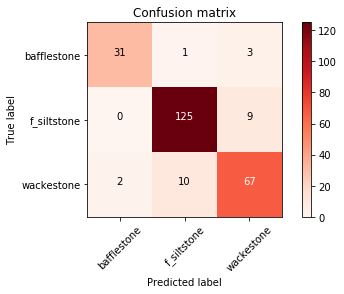

In [34]:
# itertoools is a standard library for all kinds of handy iterator manipulation
import itertools

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)

title = 'Confusion matrix'
cmap = plt.cm.Reds

# Plot non-normalized confusion matrix
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(selected))
plt.xticks(tick_marks, selected, rotation=45)
plt.yticks(tick_marks, selected)

# Print the support numbers inside the plot
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')

In [34]:
from sklearn.externals import joblib
joblib.dump(clf, 'facies_model.pkl')

['facies_model.pkl']

How do you load a saved model?

In [35]:
clf = joblib.load('facies_model.pkl')

---
# Where to go next?

- More data!
- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://github.com/Microsoft/LightGBM)
- If you want to get started on Neural Networks, [Keras](https://keras.io/) provides a scikit-learn type of experience

### Paper with classifier comparison ([link](https://arxiv.org/abs/1708.05070))

<img src="../data/model_performance.jpg"></img>

## Nuance

- Data normalization doesn't magically fix problems with data scaling. If you're lumping a bunch of well data together and the GR, say, has different ranges in each well, then the scaled data will also have this problem. So you still need to calibrate or normalize your data to ensure it's internally consistent. This is your reponsibility; `scikit-learn` scalers don't do this for you.

- Class imbalance is also your problem. You need to make sure you have good representation from all classes.


<hr />

<p style="color:gray">©2017 Agile Geoscience. Licensed CC-BY.</p>